### Imports

In [ ]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare DB

### Setup file path

In [ ]:
# Setup File Path
file_path = '/content/mock survey data 3.1.xlsx'
db_filename = '/content/hotel_survey_enhanced.db'

# Remove old DB if exists
if os.path.exists(db_filename):
    os.remove(db_filename)

### Load Data

In [ ]:
print("Loading data")
try:
    data_df = pd.read_excel(file_path, sheet_name='data')
    dict_df = pd.read_excel(file_path, sheet_name='dictionary')
except Exception as e:
    print(f"Error loading: {e}")

Loading data


## Dim tables

### Hotel

In [ ]:
# Dim_Hotel
print("Building Dim_Hotel")

# Get hotel mapping from dictionary datframe where variable is MainHotel
hotel_mapping = dict_df[dict_df['variable'] == 'MainHotel'][['value', 'label']].dropna().copy()

# Rename the column
hotel_mapping.columns = ['hotel_id', 'hotel_name']

# Convert to int type for more consistency
hotel_mapping['hotel_id'] = hotel_mapping['hotel_id'].astype(int)

# Create dimension table
dim_hotel = hotel_mapping.reset_index(drop=True)

# Create lookup dictionary mapping hotel_id to hotel_name for reference
hotel_map_dict = dict(zip(hotel_mapping['hotel_id'], hotel_mapping['hotel_name']))


Building Dim_Hotel


### Time

In [ ]:
# Dim_Time
print("Building Dim_Time")

# Get month mapping from dictionary dataframe
month_mapping = dict_df[dict_df['variable'] == 'month'][['value', 'label']].dropna().copy()

# Rename columns
month_mapping.columns = ['month_id', 'month_name']

# Convert to type int
month_mapping['month_id'] = month_mapping['month_id'].astype(int)

# Get the unique years from fact table
unique_years = data_df['year'].unique()

# Generating all year-month combi
dim_time_list = []
for year in unique_years:
    for _, row in month_mapping.iterrows():
        dim_time_list.append({
            'time_id': int(f"{year}{row['month_id']:02d}"),  # Composite key in YYYYMM format
            'year': int(year),
            'month_id': int(row['month_id']),
            'month_name': row['month_name']
        })
dim_time = pd.DataFrame(dim_time_list)

Building Dim_Time


### Visitor

In [ ]:
# Dim_Visitor
print("Building Dim_Visitor")

# Defining the demographic attributes for a unique visitor profile
profile_cols = [
    'Country of Residence', 'City of Residence',
    'Purpose of Visit', 'Main Purpose of Visit',
    'Travel Type', 'Gender', 'Marital Status',
    'Occupation', 'First Visit To Singapore'
]

# Fill nulls with 'Unknown' and remove duplicates
dim_visitor = data_df[profile_cols].fillna('Unknown').drop_duplicates().reset_index(drop=True)

# Creation of a surrogate key for each unique profile
dim_visitor.index.name = 'visitor_profile_index'
dim_visitor = dim_visitor.reset_index()
dim_visitor.rename(columns={'visitor_profile_index': 'visitor_profile_id'}, inplace=True)

# Start the visitor profile id from 1 instead of 0
dim_visitor['visitor_profile_id'] += 1

# Map back to data
data_df = data_df.merge(dim_visitor, on=profile_cols, how='left')

Building Dim_Visitor


### Entry Point

In [ ]:
# Dim_Entry_Point
print("Building Dim_Entry_Point")

# Extract air terminal mapping from dictionary dataframe
air_dict = dict_df[dict_df['variable'] == 'Air_Terminal'][['value', 'label']].dropna()
air_map = dict(zip(air_dict['value'], air_dict['label']))

# Consolidate multiple terminal cols into single entry mode and terminal name
# Returns a tuple (Entry_mode, terminal_name)
def resolve_entry_point(row):
    if pd.notna(row['Air_Terminal']):
        return 'Air', air_map.get(row['Air_Terminal'], str(row['Air_Terminal']))
    elif pd.notna(row['Sea_Terminal']):
        return 'Sea', row['Sea_Terminal']
    elif pd.notna(row['Land_Terminal']):
        return 'Land', row['Land_Terminal']
    else:
        return 'Unknown', 'Unknown'

entry_data = data_df.apply(resolve_entry_point, axis=1, result_type='expand')
entry_data.columns = ['entry_mode', 'terminal_name']

# Add to main df temporarily
data_df = pd.concat([data_df, entry_data], axis=1)

# Extract unique entry point combinations for the dimension table
dim_entry = data_df[['entry_mode', 'terminal_name']].drop_duplicates().reset_index(drop=True)

# Create surrogate key for each unique entry point
dim_entry.index.name = 'entry_index'
dim_entry = dim_entry.reset_index()
dim_entry.rename(columns={'entry_index': 'entry_point_id'}, inplace=True)

# Start entry point id from 1
dim_entry['entry_point_id'] += 1

# Map back to data
data_df = data_df.merge(dim_entry, on=['entry_mode', 'terminal_name'], how='left')


Building Dim_Entry_Point


### Travel Party

In [ ]:
# Dim_Travel_Party
print("Building Dim_Travel_Party")

# Identify all travel companion flag columns
companion_cols = [c for c in data_df.columns if 'Travel companion' in c]

# Extract the companion type
def get_party_desc(row):
    companions = []
    for col in companion_cols:
        if row[col] == 1:
            # Extract name "Spouse" from "Travel companion - Spouse"
            name = col.replace('Travel companion - ', '')
            companions.append(name)
    return ", ".join(companions) if companions else "None"

# Get unique combinations of companion flags
party_groups = data_df[companion_cols].drop_duplicates().reset_index(drop=True)

# Generate a descriptive label for each uniquq combination
party_groups['party_description'] = party_groups.apply(get_party_desc, axis=1)

# Create surrogate key for each unique travel party
party_groups.index.name = 'party_index'
dim_party = party_groups.reset_index()
dim_party.rename(columns={'party_index': 'party_id'}, inplace=True)

# Start party id from 1
dim_party['party_id'] += 1

# Map back to data
data_df = data_df.merge(dim_party, on=companion_cols, how='left')

Building Dim_Travel_Party


## Fact table

In [ ]:
# Hotel Group Logic

# Assign hotel to group based on the rule
# - Village hotel albert coutry and bugis merge into Town Hotel Group
# from Nov onwards
def get_hotel_group(row):
    hotel_id = row['MainHotel']
    month = row['month']

    # Handling missing data
    if pd.isna(hotel_id): return "Unknown"

    # Lookup hotel name from mapping dict
    hotel_name = hotel_map_dict.get(hotel_id, "Unknown")

    # Applying the date grouping rule
    if hotel_name in ['Village Hotel Albert Court', 'Village Hotel Bugis']:
        if month >= 11:
            return "Town Hotel Group"
        else:
            return hotel_name
    return hotel_name

data_df['Hotel_Group'] = data_df.apply(get_hotel_group, axis=1)

# Generate composite key in YYYYMM format
data_df['time_id'] = data_df.apply(lambda x: int(f"{int(x['year'])}{int(x['month']):02d}"), axis=1)

# Fact table columns
shopping_cols = [
    'shopping_fash', 'shopping_jewllery', 'shopping_watches', 'shopping_wellness',
    'shopping_food', 'shopping_gifts', 'shopping_consumertech',
    'shopping_antiques', 'shopping_others', 'shopping_any'
]

expense_cols = [
    'totacc', 'totfnb', 'tottran', 'totbiz', 'totedu',
    'totmedi', 'tototh', 'totshopping', 'tot.exp'
]

# FK and business attris
fact_keys = ['case', 'time_id', 'MainHotel', 'visitor_profile_id',
             'entry_point_id', 'party_id', 'Hotel_Group']

# Combine all columns
all_fact_cols = fact_keys + expense_cols + shopping_cols

# Filter to only columns that are in the DF
available_fact_cols = [c for c in all_fact_cols if c in data_df.columns]
fact_survey = data_df[available_fact_cols].copy()

# Rename keys for clarity
fact_survey.rename(columns={
    'case': 'case_id',
    'MainHotel': 'hotel_id',
    'tot.exp': 'total_expenditure'
}, inplace=True)

# Hnadle missing hotel IDs
fact_survey['hotel_id'] = fact_survey['hotel_id'].fillna(-1).astype(int)

### Create DB

In [ ]:
print(f"Writing to {db_filename}")
conn = sqlite3.connect(db_filename)

# Writing dim table to DB
dim_hotel.to_sql('Dim_Hotel', conn, if_exists='replace', index=False)
dim_time.to_sql('Dim_Time', conn, if_exists='replace', index=False)
dim_visitor.to_sql('Dim_Visitor', conn, if_exists='replace', index=False)
dim_entry.to_sql('Dim_Entry_Point', conn, if_exists='replace', index=False)
dim_party.to_sql('Dim_Travel_Party', conn, if_exists='replace', index=False)

# Writing fact table to DB
fact_survey.to_sql('Fact_Survey', conn, if_exists='replace', index=False)

# Create index for query performance
cursor = conn.cursor()
cursor.execute("CREATE INDEX IF NOT EXISTS idx_grp ON Fact_Survey(Hotel_Group)")
cursor.execute("CREATE INDEX IF NOT EXISTS idx_pty ON Fact_Survey(party_id)")
cursor.execute("CREATE INDEX IF NOT EXISTS idx_ent ON Fact_Survey(entry_point_id)")
conn.commit()
conn.close()

print("Database generation complete!")

Writing to /content/hotel_survey_enhanced.db
Database generation complete!


# Queries

### What is the total expenditure trend of visitors who stayed in Village Hotel Albert Court by month?

In [ ]:
conn = sqlite3.connect(db_filename)
query1 = """
SELECT
    T.year,
    T.month_name,
    SUM(F.total_expenditure) as Total_Expenditure
FROM Fact_Survey F
JOIN Dim_Hotel H ON F.hotel_id = H.hotel_id
JOIN Dim_Time T ON F.time_id = T.time_id
WHERE H.hotel_name = 'Village Hotel Albert Court'
GROUP BY T.year, T.month_id, T.month_name
ORDER BY T.year, T.month_id;
"""

df_trend = pd.read_sql(query1, conn)
display(df_trend)

,year,month_name,Total_Expenditure
0,2018,Jan,5483.77
1,2018,Feb,1626.50
2,2018,Mar,13868.77
3,2018,April,10903.87
4,2018,May,24745.39
5,2018,June,22199.15
6,2018,July,27216.07
7,2018,Aug,35385.96
8,2018,Sep,19046.58
9,2018,Oct,45514.13


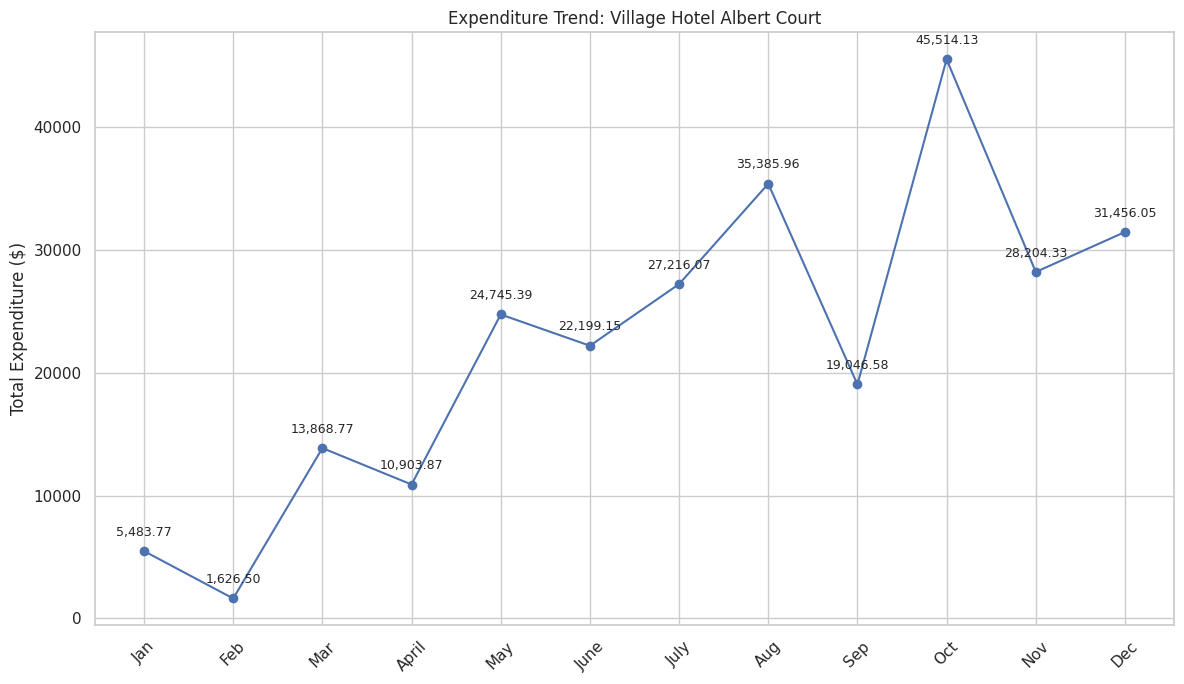

In [ ]:
# Plot the trend
plt.figure(figsize=(12, 7))
plt.plot(df_trend['month_name'], df_trend['Total_Expenditure'], marker='o')
plt.title('Expenditure Trend: Village Hotel Albert Court')
plt.ylabel('Total Expenditure ($)')
plt.xticks(rotation=45)
plt.grid(True)

for i, txt in enumerate(df_trend['Total_Expenditure']):
    plt.text(df_trend['month_name'][i], df_trend['Total_Expenditure'][i] + 1000, f'{txt:,.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Which nationality has the highest FnB spend for each of the following:
1. Village Hotel Albert Court
2. Village Hotel Bugis
3. Town Hotel Group


In [ ]:
query2 = """WITH Nationality_Spend AS (
    -- 1. Calculate Total FnB Spend by Hotel Group and Nationality
    SELECT
        F.Hotel_Group,
        V."Country of Residence" AS Nationality,
        SUM(F.totfnb) AS Total_FnB_Spend
    FROM Fact_Survey F
    JOIN Dim_Visitor V ON F.visitor_profile_id = V.visitor_profile_id
    WHERE F.Hotel_Group IN ('Village Hotel Albert Court', 'Village Hotel Bugis', 'Town Hotel Group')
    GROUP BY F.Hotel_Group, V."Country of Residence"
),
Ranked_Spend AS (
    -- 2. Rank the Nationalities (1 = Highest Spend)
    SELECT
        Hotel_Group,
        Nationality,
        Total_FnB_Spend,
        RANK() OVER (PARTITION BY Hotel_Group ORDER BY Total_FnB_Spend DESC) as rank
    FROM Nationality_Spend
)
-- 3. Select only the top rank for each group
SELECT
    Hotel_Group,
    Nationality,
    Total_FnB_Spend
FROM Ranked_Spend
WHERE rank = 1;"""

df_query2 = pd.read_sql(query2, conn)
display(df_query2)

,Hotel_Group,Nationality,Total_FnB_Spend
0,Town Hotel Group,Indonesia,2915.59
1,Village Hotel Albert Court,Indonesia,4524.30
2,Village Hotel Bugis,Indonesia,7260.54


### What was the revenue of Town Hotel Group for the entire year?

In [ ]:
query3 = """
SELECT
    SUM(F.total_expenditure) AS Total_Annual_Revenue
FROM Fact_Survey F
JOIN Dim_Hotel H ON F.hotel_id = H.hotel_id
WHERE H.hotel_name IN ('Village Hotel Albert Court', 'Village Hotel Bugis')
  AND F.time_id BETWEEN 201801 AND 201812;"""

df_query3 = pd.read_sql(query3, conn)
display(df_query3)

,Total_Annual_Revenue
0,530984.7


## Part D Extra

In [ ]:
# Segment into Business vs Leisure
def segment_purpose(purpose):
    if pd.isna(purpose):
        return 'Unknown'
    if 'Business' in str(purpose):
        return 'Business'
    elif 'Leisure' in str(purpose):
        return 'Leisure'
    else:
        return 'Other'

data_df['Segment'] = data_df['Purpose of Visit'].apply(segment_purpose)

# Filter for only Business and Leisure
analysis_df = data_df[data_df['Segment'].isin(['Business', 'Leisure'])].copy()

sns.set(style="whitegrid")

### Spend comparison chart

/tmp/ipython-input-3151845094.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Segment', y='tot.exp', data=avg_spend, palette=['#4c72b0', '#55a868'])


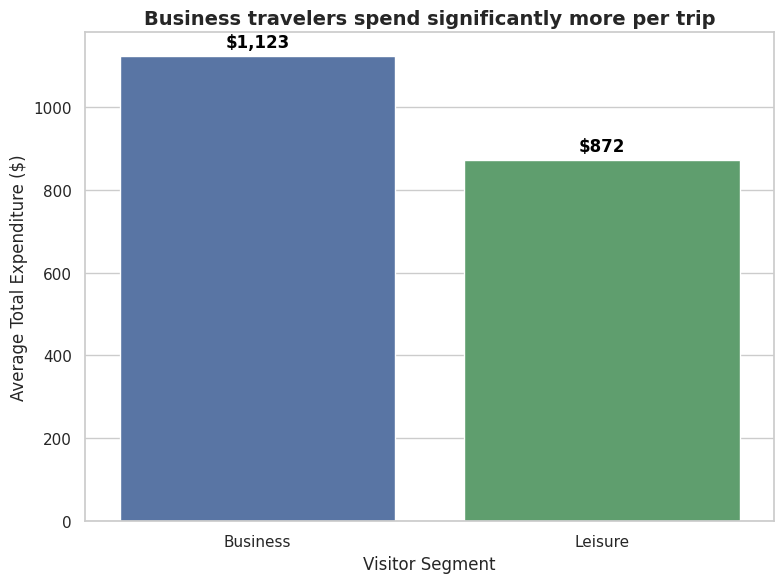

In [ ]:
spend_metrics = ['tot.exp', 'totshopping', 'totfnb', 'totacc']
avg_spend = analysis_df.groupby('Segment')[spend_metrics].mean().reset_index()

plt.figure(figsize=(8, 6))
# Plot Total Expenditure
sns.barplot(x='Segment', y='tot.exp', data=avg_spend, palette=['#4c72b0', '#55a868'])
plt.title('Business travelers spend significantly more per trip', fontsize=14, fontweight='bold')
plt.ylabel('Average Total Expenditure ($)', fontsize=12)
plt.xlabel('Visitor Segment', fontsize=12)

for index, row in avg_spend.iterrows():
    plt.text(index, row['tot.exp'] + 20, f"${row['tot.exp']:,.0f}", color='black', ha="center", fontweight='bold')

plt.tight_layout()
plt.show()

/tmp/ipython-input-4132468446.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Category', y='Amount', data=plot_data, palette='viridis')


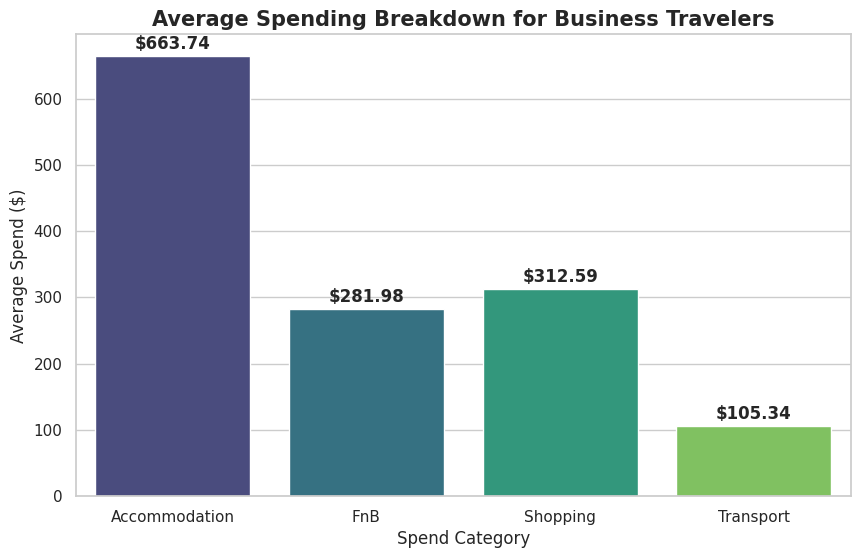

In [ ]:
q1_query = """
SELECT
    -- Segment the visitors
    'Business' AS Visitor_Segment,

    -- Calculate Average Spends
    ROUND(AVG(F.totacc), 2) AS Avg_Accommodation_Spend,
    ROUND(AVG(F.totfnb), 2) AS Avg_FnB_Spend,
    ROUND(AVG(F.totshopping), 2) AS Avg_Shopping_Spend,
    ROUND(AVG(F.tottran), 2) AS Avg_Transport_Spend
    -- Excluded Total_Spend from plot to focus on the breakdown components

FROM Fact_Survey F
JOIN Dim_Visitor V ON F.visitor_profile_id = V.visitor_profile_id
WHERE V."Purpose of Visit" LIKE '%Business%'
GROUP BY Visitor_Segment;
"""

df_q1 = pd.read_sql(q1_query, conn)

# Melt dataframe to turn columns into rows for easier plotting
plot_data = df_q1.melt(id_vars='Visitor_Segment',
                       var_name='Category',
                       value_name='Amount')

# Clean up Category names for the chart (remove 'Avg_' and '_Spend')
plot_data['Category'] = plot_data['Category'].str.replace('Avg_', '').str.replace('_Spend', '')

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create Bar Plot
ax = sns.barplot(x='Category', y='Amount', data=plot_data, palette='viridis')

plt.title('Average Spending Breakdown for Business Travelers', fontsize=15, fontweight='bold')
plt.ylabel('Average Spend ($)', fontsize=12)
plt.xlabel('Spend Category', fontsize=12)

for p in ax.patches:
    ax.annotate(f'${p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontweight='bold')

plt.show()

### Shopping breakdown chart

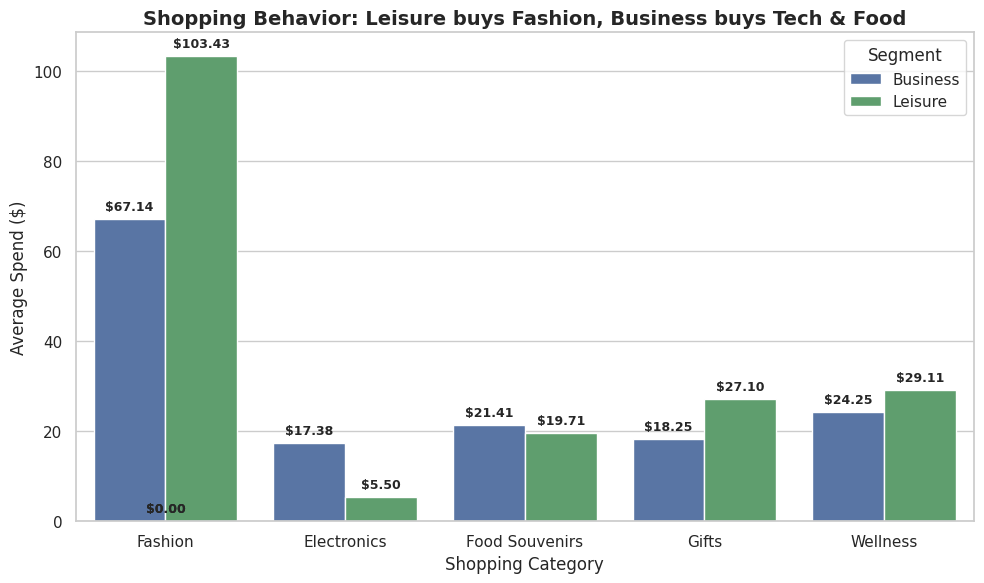

In [ ]:
# Define shopping columns
shopping_cols = [
    'shopping_fash', 'shopping_consumertech', 'shopping_food',
    'shopping_gifts', 'shopping_wellness'
]
# Rename for cleaner labels
col_map = {
    'shopping_fash': 'Fashion',
    'shopping_consumertech': 'Electronics',
    'shopping_food': 'Food Souvenirs',
    'shopping_gifts': 'Gifts',
    'shopping_wellness': 'Wellness'
}

# Calculate averages
avg_shopping = analysis_df.groupby('Segment')[shopping_cols].mean().rename(columns=col_map)

# Reshape for plotting
shopping_melted = avg_shopping.reset_index().melt(id_vars='Segment', var_name='Category', value_name='Avg Spend')

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Category', y='Avg Spend', hue='Segment', data=shopping_melted, palette=['#4c72b0', '#55a868'])

plt.title('Shopping Behavior: Leisure buys Fashion, Business buys Tech & Food', fontsize=14, fontweight='bold')
plt.ylabel('Average Spend ($)', fontsize=12)
plt.xlabel('Shopping Category', fontsize=12)
plt.legend(title='Segment')

for p in ax.patches:
    ax.annotate(f'${p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontweight='bold',
                fontsize=9)

plt.tight_layout()
plt.show()

### Top spending markets

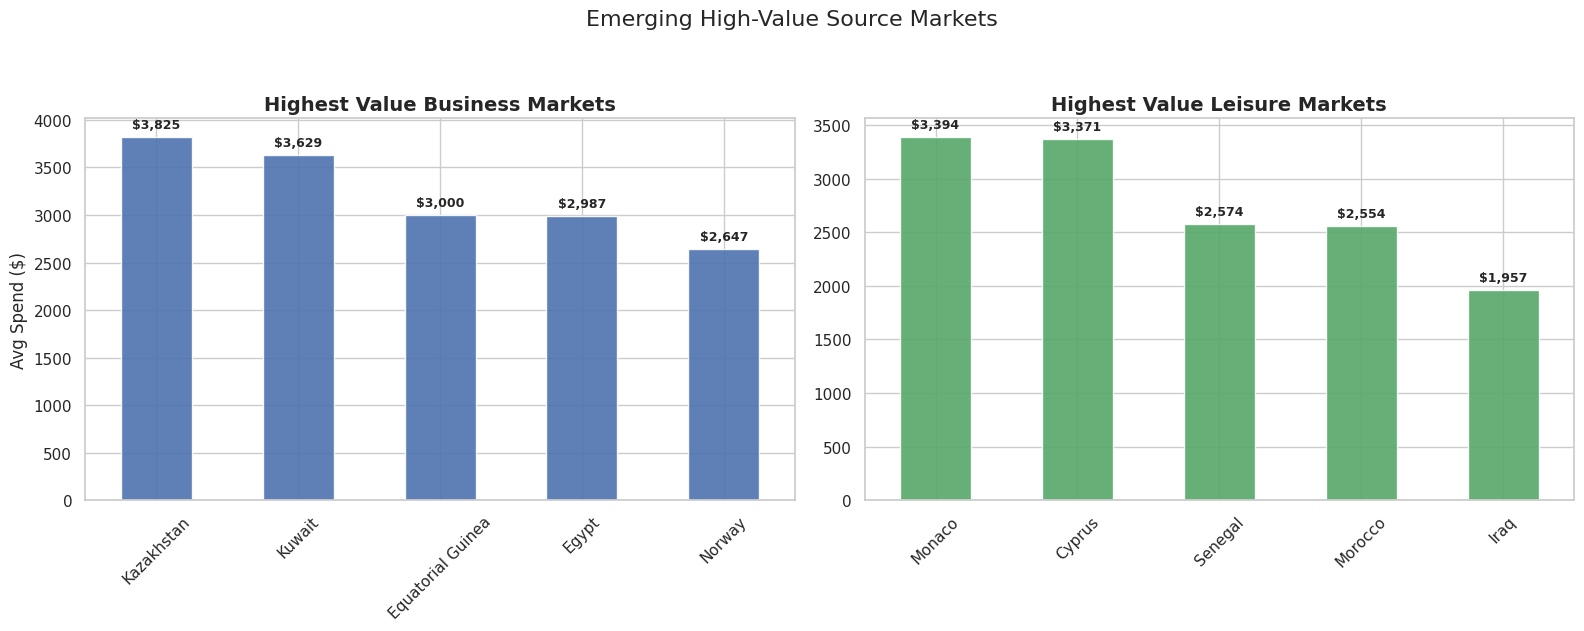

In [ ]:
# Get Top 5 Business Markets
top_biz = analysis_df[analysis_df['Segment']=='Business'].groupby('Country of Residence')['tot.exp'].mean().nlargest(5)
# Get Top 5 Leisure Markets
top_leisure = analysis_df[analysis_df['Segment']=='Leisure'].groupby('Country of Residence')['tot.exp'].mean().nlargest(5)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Business
ax0 = top_biz.plot(kind='bar', ax=axes[0], color='#4c72b0', alpha=0.9)
axes[0].set_title('Highest Value Business Markets', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Avg Spend ($)')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)

for p in ax0.patches:
    ax0.annotate(f'${p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontweight='bold',
                fontsize=9)

# Plot Leisure
ax1 = top_leisure.plot(kind='bar', ax=axes[1], color='#55a868', alpha=0.9)
axes[1].set_title('Highest Value Leisure Markets', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45)
for p in ax1.patches:
    ax1.annotate(f'${p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontweight='bold',
                fontsize=9)

plt.suptitle('Emerging High-Value Source Markets', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()